In [48]:
from config import api_key
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress


In [39]:
base_url=f"https://api.covidactnow.org/v2/states.json?apiKey={api_key}"
response=requests.get(base_url).json()

In [40]:
response[2]

{'fips': '05',
 'country': 'US',
 'state': 'AR',
 'county': None,
 'level': 'state',
 'lat': None,
 'locationId': 'iso1:us#iso2:us-ar',
 'long': None,
 'population': 3017804,
 'metrics': {'testPositivityRatio': 0.056,
  'testPositivityRatioDetails': {'source': 'other'},
  'caseDensity': 16.8,
  'contactTracerCapacityRatio': 0.31,
  'infectionRate': 0.9,
  'infectionRateCI90': 0.1,
  'icuCapacityRatio': 0.83,
  'vaccinationsInitiatedRatio': 0.575,
  'vaccinationsCompletedRatio': 0.475},
 'riskLevels': {'overall': 2,
  'testPositivityRatio': 1,
  'caseDensity': 2,
  'contactTracerCapacityRatio': 1,
  'infectionRate': 0,
  'icuCapacityRatio': 2},
 'cdcTransmissionLevel': 3,
 'actuals': {'cases': 509559,
  'deaths': 8255,
  'positiveTests': 316362,
  'negativeTests': 3364799,
  'contactTracers': 790,
  'hospitalBeds': {'capacity': 9274,
   'currentUsageTotal': 6793,
   'currentUsageCovid': 523},
  'icuBeds': {'capacity': 946,
   'currentUsageTotal': 786,
   'currentUsageCovid': 164},
  'ne

In [41]:
state=response[0]["state"]
population=response[0]["population"]
case_density=response[0]["metrics"]["caseDensity"]
icu_capacity=response[0]["metrics"]["icuCapacityRatio"]
vax_initiated=response[0]["metrics"]["vaccinationsInitiatedRatio"]
vax_completed=response[0]["metrics"]["vaccinationsCompletedRatio"]
cases=response[0]["actuals"]["cases"]
deaths=response[0]["actuals"]["deaths"]
pos_tests=response[0]["actuals"]["positiveTests"]
neg_tests=response[0]["actuals"]["negativeTests"]
hospital_beds_capacity=response[0]["actuals"]["hospitalBeds"]["capacity"]
hospital_beds_current_usage=response[0]["actuals"]["hospitalBeds"]["currentUsageTotal"]
hospital_beds_covid_usage=response[0]["actuals"]["hospitalBeds"]["currentUsageCovid"]
icu_beds_capacity=response[0]["actuals"]["icuBeds"]["capacity"]
icu_beds_current_usage=response[0]["actuals"]["icuBeds"]["currentUsageTotal"]
icu_beds_covid_usage=response[0]["actuals"]["icuBeds"]["currentUsageCovid"]
last_update_date=response[0]["lastUpdatedDate"]

In [42]:
# Create empty lists to store the data for each field
state_name = []
population = []
case_density = []
icu_capacity_ratio = []
vax_initiated = []
vax_completed = []
cases = []
deaths = []
pos_tests = []
neg_tests = []
hospital_beds_capacity=[]
hospital_beds_current_usage=[]
hospital_beds_covid_usage=[]
icu_beds_capacity=[]
icu_beds_current_usage=[]
icu_beds_covid_usage=[]
last_update_date=[]
pos_case_rate = []

# Loop through cities
for i in list(range(len(response))):
    
        # Get the JSON response from the OpenWeather API
    state_name.append(response[i]["state"])
    population.append(response[i]["population"])
    case_density.append(response[i]["metrics"]["caseDensity"])
    icu_capacity_ratio.append(response[i]["metrics"]["icuCapacityRatio"])
    vax_initiated.append(response[i]["metrics"]["vaccinationsInitiatedRatio"])
    vax_completed.append(response[i]["metrics"]["vaccinationsCompletedRatio"])
    cases.append(response[i]["actuals"]["cases"])
    deaths.append(response[i]["actuals"]["deaths"])
    pos_tests.append(response[i]["actuals"]["positiveTests"])
    neg_tests.append(response[i]["actuals"]["negativeTests"])
    hospital_beds_capacity.append(response[i]["actuals"]["hospitalBeds"]["capacity"])
    hospital_beds_current_usage.append(response[i]["actuals"]["hospitalBeds"]["currentUsageTotal"])
    hospital_beds_covid_usage.append(response[i]["actuals"]["hospitalBeds"]["currentUsageCovid"])
    icu_beds_capacity.append(response[i]["actuals"]["icuBeds"]["capacity"])
    icu_beds_current_usage.append(response[i]["actuals"]["icuBeds"]["currentUsageTotal"])
    icu_beds_covid_usage.append(response[i]["actuals"]["icuBeds"]["currentUsageCovid"])
    last_update_date.append(response[i]["lastUpdatedDate"])
    pos_case_rate.append((response[i]["actuals"]["positiveTests"]*100)/(response[i]["actuals"]["negativeTests"]+response[i]["actuals"]["positiveTests"]))


In [43]:
df=pd.DataFrame({"State": state_name, "Population":population, "Case Density": case_density, 
                 "ICU Capacity Ratio": icu_capacity_ratio, "Initiated Vaccinations": vax_initiated, 
                 "Completed Vaccinations": vax_completed,"Total Number of Cases": cases,"Death Toll": deaths,
                 "Positive Tests": pos_tests, "Negative Tests":neg_tests, "Positive Case Rate": pos_case_rate,"Hospital Beds Capacity": hospital_beds_capacity,
                 "Hospital Beds Current Usage": hospital_beds_current_usage,"Hospital Beds COVID Usage":hospital_beds_covid_usage,
                 "ICU Beds Capacity":icu_beds_capacity,"ICU Beds Current Usage":icu_beds_current_usage,
                 "ICU Beds COVID Usage":icu_beds_covid_usage, "Last Update Date": last_update_date,})

#df.style.format({'Positive Case Rate':'{:,.2f}%'})
df

,State,Population,Case Density,ICU Capacity Ratio,Initiated Vaccinations,Completed Vaccinations,Total Number of Cases,Death Toll,Positive Tests,Negative Tests,Positive Case Rate,Hospital Beds Capacity,Hospital Beds Current Usage,Hospital Beds COVID Usage,ICU Beds Capacity,ICU Beds Current Usage,ICU Beds COVID Usage,Last Update Date
0,AK,731545,107.4,0.85,0.588,0.522,132393,680,150919,2910137,4.930292,1623.0,1242.0,234.0,133.0,113.0,48.0,2021-10-23
1,AL,4903185,17.4,0.85,0.539,0.443,816087,15378,772285,5193274,12.945727,14798.0,11406.0,799.0,1580.0,1349.0,207.0,2021-10-23
2,AR,3017804,16.8,0.83,0.575,0.475,509559,8255,316362,3364799,8.594082,9274.0,6793.0,523.0,946.0,786.0,164.0,2021-10-23
3,AZ,7278717,30.8,0.65,0.608,0.526,1143855,20826,1167486,9512191,10.931847,17265.0,13053.0,1703.0,2174.0,1423.0,429.0,2021-10-23
4,CA,39512223,14.0,0.77,0.738,0.607,4867059,71504,4838152,80836787,5.647103,65001.0,51185.0,4006.0,7044.0,5391.0,964.0,2021-10-23
5,CO,5758736,37.9,0.87,0.671,0.610,724074,8202,719187,9941186,6.746359,11880.0,8775.0,1260.0,1301.0,1136.0,370.0,2021-10-23
6,CT,3565287,12.4,0.58,0.782,0.702,399402,8739,524381,10609271,4.709874,8463.0,7007.0,246.0,1024.0,595.0,69.0,2021-10-23
7,DC,705749,12.4,0.80,0.733,0.619,63588,1186,91389,2832372,3.125734,3493.0,2821.0,91.0,343.0,274.0,17.0,2021-10-23
8,DE,973764,34.3,0.84,0.684,0.594,141717,2045,159696,2506996,5.988543,3383.0,2677.0,195.0,199.0,168.0,25.0,2021-10-23
9,FL,21477737,9.7,0.77,0.686,0.592,3631256,58803,4286562,36998340,10.382880,58079.0,46015.0,2525.0,6451.0,4999.0,622.0,2021-10-23


In [44]:
final_df=df.dropna()

In [45]:
final_df.to_csv(r"C:\Users\cchic\OneDrive\Documents\projects_challenges\Project_1_COVID19_Team_ABC\outputfile.csv")

In [46]:
final_df.head()

,State,Population,Case Density,ICU Capacity Ratio,Initiated Vaccinations,Completed Vaccinations,Total Number of Cases,Death Toll,Positive Tests,Negative Tests,Positive Case Rate,Hospital Beds Capacity,Hospital Beds Current Usage,Hospital Beds COVID Usage,ICU Beds Capacity,ICU Beds Current Usage,ICU Beds COVID Usage,Last Update Date
0,AK,731545,107.4,0.85,0.588,0.522,132393,680,150919,2910137,4.930292,1623.0,1242.0,234.0,133.0,113.0,48.0,2021-10-23
1,AL,4903185,17.4,0.85,0.539,0.443,816087,15378,772285,5193274,12.945727,14798.0,11406.0,799.0,1580.0,1349.0,207.0,2021-10-23
2,AR,3017804,16.8,0.83,0.575,0.475,509559,8255,316362,3364799,8.594082,9274.0,6793.0,523.0,946.0,786.0,164.0,2021-10-23
3,AZ,7278717,30.8,0.65,0.608,0.526,1143855,20826,1167486,9512191,10.931847,17265.0,13053.0,1703.0,2174.0,1423.0,429.0,2021-10-23
4,CA,39512223,14.0,0.77,0.738,0.607,4867059,71504,4838152,80836787,5.647103,65001.0,51185.0,4006.0,7044.0,5391.0,964.0,2021-10-23


LinregressResult(slope=-483.87786491877404, intercept=542.5615656030393, rvalue=-0.13744228023936306, pvalue=0.3312302862451755, stderr=493.1615044170406, intercept_stderr=279.9199275729124)


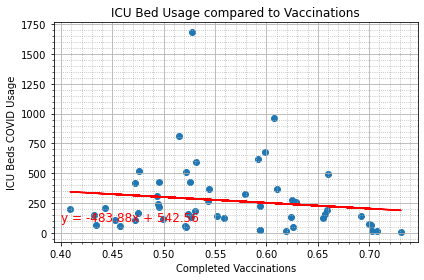

In [61]:
x_values = final_df["Completed Vaccinations"]
y_values = final_df["ICU Beds COVID Usage"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)

plt.scatter(x_values,y_values)
plt.title('ICU Bed Usage compared to Vaccinations')
plt.xlabel('Completed Vaccinations')
plt.ylabel('ICU Beds COVID Usage')
plt.plot(x_values,regress_values,"r-")
print(correlation)
plt.annotate(line_eq,(0.4,100),fontsize=12,color="red")
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

LinregressResult(slope=0.13952432264505332, intercept=5945.324923154316, rvalue=0.9673368920415053, pvalue=1.830375951367254e-31, stderr=0.005170770836888821, intercept_stderr=49843.13030871424)


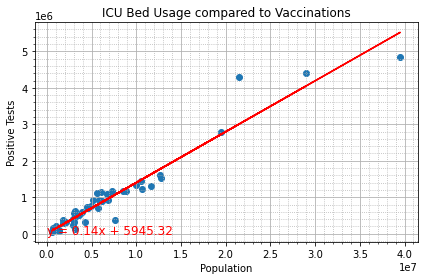

In [62]:
x_values = final_df["Population"]
y_values = final_df["Positive Tests"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)

plt.scatter(x_values,y_values)
plt.title('Population compared to Positive Tests')
plt.xlabel('Population')
plt.ylabel('Positive Tests')
plt.plot(x_values,regress_values,"r-")
print(correlation)
plt.annotate(line_eq,(0.4,100),fontsize=12,color="red")
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

LinregressResult(slope=0.002216686784465523, intercept=10.045537369345766, rvalue=0.9636109388162281, pvalue=2.6085485439950187e-30, stderr=8.696224752441356e-05, intercept_stderr=838.2639208017961)


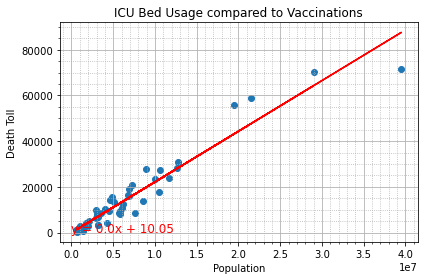

In [63]:
x_values = final_df["Population"]
y_values = final_df["Death Toll"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)

plt.scatter(x_values,y_values)
plt.title('ICU Bed Usage compared to Vaccinations')
plt.xlabel('Population')
plt.ylabel('Death Toll')
plt.plot(x_values,regress_values,"r-")
print(correlation)
plt.annotate(line_eq,(0.4,100),fontsize=12,color="red")
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()

LinregressResult(slope=-74.43816884337993, intercept=71.80468089546885, rvalue=-0.3165094715692182, pvalue=0.022253176106929874, stderr=31.550206955625026, intercept_stderr=17.907990722772624)


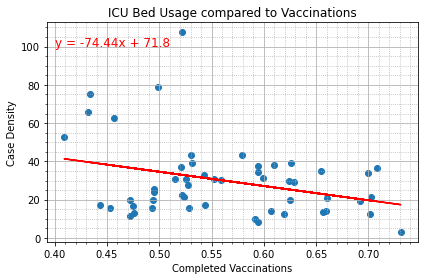

In [65]:
x_values = final_df["Completed Vaccinations"]
y_values = final_df["Case Density"]

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)

plt.scatter(x_values,y_values)
plt.title('ICU Bed Usage compared to Vaccinations')
plt.xlabel('Completed Vaccinations')
plt.ylabel('Case Density')
plt.plot(x_values,regress_values,"r-")
print(correlation)
plt.annotate(line_eq,(0.4,100),fontsize=12,color="red")
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.show()